## GMM Estimation of Model Parameters of Expectation Formation

- This notebook includes functions that estimate the parameter of rigidity for different models
- It allows for flexible choices of moments to be used, forecast error, disagreement, and uncertainty, etc. 
- It includes 
  - A general function that implements the estimation using the minimum distance algorithm. 
  - Model-specific functions that take real-time data and process parameters as inputs and produces forecasts and moments as outputs. It is model-specific because different models of expectation formation bring about different forecasts. 
  - Auxiliary functions that compute the moments as well as the difference of data and model prediction, which will be used as inputs for GMM estimator. 

### 1. Estimation algorithms 

In [1]:
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.api import AR
import copy as cp 
from scipy.stats import bernoulli

In [2]:
# a general-purpose estimating function of the parameter
def Estimator(obj_func,
              para_guess,
              method='CG',
              bounds = None,
              options = {'disp': True}):
    """
    Inputs
    ------
    - moments: a function of the rigidity model parameter  
    - method: method of optimization, i.e. 
         -  'L-BFGS-B', bounds=((1e-10, None), (1e-10, None))
    
    Outputs
    -------
    - parameter: an array of estimated parameter
    """
    
    parameter = minimize(obj_func,
                         x0 = para_guess,
                         method = method,
                         bounds = bounds,
                         options = options)['x']
    return parameter 

In [3]:
# a function that prepares moment conditions. So far the loss being simply the norm of the difference
def PrepMom(model_moments,
            data_moments):
    """
    Inputs
    -----
    model_moments: an array of moments from a certain model, i.e. forecast error, disagreement and uncertainty. 
    data_moments: an array of moments computed from the survey data
    
    Outputs
    ------
    diff: the Euclidean distance of two arrays of data and model 
    
    """
    diff = np.linalg.norm(model_moments - data_moments)
    return diff

In [4]:
## auxiliary functions 
def hstepvar(h,sigma,rho):
    return sum([ rho**(2*i)*sigma**2 for i in range(h)] )

np.random.seed(12345)
def hstepfe(h,sigma,rho):
    return sum([rho**i*(np.random.randn(1)*sigma)*np.random.randn(h)[i] for i in range(h)])
## This is not correct. 


def ForecastPlot(test):
    x = plt.figure(figsize=([3,13]))
    for i,val in enumerate(test):
        plt.subplot(4,1,i+1)
        plt.plot(test[val],label=val)
        plt.legend(loc=1)
    return x
        
def ForecastPlotDiag(test,data,legends=['model','data']):
    x = plt.figure(figsize=([3,13]))
    for i,val in enumerate(test):
        plt.subplot(4,1,i+1)
        plt.plot(test[val],label= legends[0]+ ': ' +val)
        plt.plot(np.array(data[val]),label=legends[1] +': '+ val)
        plt.legend(loc=1)
    return x
        
### AR1 simulator 
def AR1_simulator(rho,sigma,nobs):
    xxx = np.zeros(nobs+1)
    shocks = np.random.randn(nobs+1)*sigma
    xxx[0] = 0 
    for i in range(nobs):
        xxx[i+1] = rho*xxx[i] + shocks[i+1]
    return xxx[1:]

In [5]:
## some process parameters 
rho = 0.95
sigma = 0.1
process_para = {'rho':rho,
                'sigma':sigma}

In [6]:
## Rational Expectation (RE) class 
class RationalExpectation:
    def __init__(self,
                 real_time,
                 history,
                 horizon=1,
                 process_para = process_para,
                 exp_para = {},
                 moments=['Forecast','FE','Disg','Var']):
        self.real_time = real_time
        self.history = history
        self.horizon = horizon
        self.process_para = process_para
        self.moments = moments
    
    def GetRealization(self,realized_series):
        self.realized = realized_series
        
    def SimulateRealization(self):
        n = len(self.real_time)
        rho = self.process_para['rho']
        sigma =self.process_para['sigma']
        shocks = np.random.randn(n)*sigma
        realized = np.zeros(n)
        for i in range(n):
            cum_shock = sum([rho**h*shocks[h] for h in range(self.horizon)])
            realized[i] = rho**self.horizon*self.real_time[i] + cum_shock
        self.realized = realized        
        
    def Forecaster(self):
        ## parameters
        n = len(self.real_time)
        rho = self.process_para['rho']
        sigma =self.process_para['sigma']
        
        ## parameters
        real_time = self.real_time
        horizon = self.horizon
        
        ## forecast moments 
        Disg =np.zeros(n)
        infoset = real_time
        nowcast = infoset
        forecast = rho**horizon*nowcast
        Var = hstepvar(horizon,sigma,rho)* np.ones(n)
        FE = forecast - self.realized ## forecast errors depend on realized shocks 
        self.forecast_moments = {"Forecast":forecast,
                                 "FE":FE,
                                 "Disg":Disg,
                                 "Var":Var}
        return self.forecast_moments
        
    def RE_EstObjfunc(self,
                      process_para):
        """
        input
        -----
        process_para: the parameters of process to be estimated. 
           No expectation parameters because rational expectation
        
        output
        -----
        the objective function to minmize
        """
        moments = self.moments
        re_process_para = {'rho':process_para[0],
                  'sigma':process_para[1]}
        self.process_para = re_process_para  # give the process para
        data_moms_dct = self.data_moms_dct
        RE_moms_dct = self.Forecaster().copy()
        RE_moms = np.array([RE_moms_dct[key] for key in moments] )
        data_moms = np.array([data_moms_dct[key] for key in moments] )
        obj_func = PrepMom(RE_moms,data_moms)
        return obj_func 
    
    def GetDataMoments(self,
                       data_moms_dct):
        self.data_moms_dct = data_moms_dct
    
    def ParaEstimate(self,
                     para_guess = np.array([0.5,0.1]),
                     method = 'CG',
                     bounds = None,
                     options = None):
        self.para_est = Estimator(self.RE_EstObjfunc,
                                  para_guess = para_guess,
                                  method = method,
                                  bounds = bounds,
                                  options = options)
    
    def ForecastPlot(self):
        x = plt.figure(figsize=([3,13]))
        for i,val in enumerate(self.moments):
            plt.subplot(4,1,i+1)
            plt.plot(self.forecast_moments[val],label=val)
            plt.legend(loc=1)
            
    def ForecastPlotDiag(self):
        re_process_est_dct = {'rho':self.para_est[0],
                           'sigma':self.para_est[1]}
        new_instance = cp.deepcopy(self)
        new_instance.process_para = re_process_est_dct
        self.forecast_moments_est = new_instance.Forecaster()
        x = plt.figure(figsize=([3,13]))
        for i,val in enumerate(self.moments):
            plt.subplot(4,1,i+1)
            plt.plot(self.forecast_moments_est[val],'r-',label='model:'+ val)
            plt.plot(np.array(self.data_moms_dct[val]),'*',label='data:'+ val)
            plt.legend(loc=1)

In [7]:
### create a RE instance 
xx_history = AR1_simulator(rho,sigma,100)
xx_real_time = xx_history[20:]

RE_instance = RationalExpectation(real_time = xx_real_time,
                                 history = xx_history)

In [8]:
### simulate a realized series 
#RE_instance.SimulateRealization()

### forecster
#fe_moms = RE_instance.Forecaster()
#RE_instance.ForecastPlot()

In [9]:
## estimate rational expectation model 
#RE_instance.GetDataMoments(fe_moms)
#RE_instance.moments=['Forecast','FE','Var']

#RE_instance.ParaEstimate(para_guess = np.array([0.9,0.2]),
#                         method = 'L-BFGS-B',
#                         bounds =((0,1),(0,1)),
#                         options = {'disp':True})
#RE_instance.para_est
#RE_instance.ForecastPlotDiag()

In [167]:
## SE expectation parameters 
SE_para_default = {'lambda':0.2}

In [168]:
## Sticky Expectation(SE) class 
class StickyExpectation:
    def __init__(self,
                 real_time,
                 history,
                 horizon=1,
                 process_para = process_para,
                 exp_para = SE_para_default,
                 max_back =10,
                 moments = ['Forecast','Disg','Var']):
        self.history = history
        self.real_time = real_time
        self.n = len(real_time)
        self.horizon = horizon
        self.process_para = process_para
        self.exp_para = exp_para
        self.max_back = max_back
        self.data_moms_dct ={}
        self.para_est = {}
        self.moments = moments
        self.realized = None
        self.sim_realized = None
        
    def GetRealization(self,
                       realized_series):
        self.realized = realized_series   
    
    def SimulateRealization(self):
        n = self.n
        rho = self.process_para['rho']
        sigma =self.process_para['sigma']
        shocks = np.random.randn(n)*sigma
        sim_realized = np.zeros(n)
        for i in range(n):
            cum_shock = sum([rho**h*shocks[h] for h in range(self.horizon)])
            sim_realized[i] = rho**self.horizon*self.real_time[i] + cum_shock
        self.sim_realized = sim_realized
        return self.sim_realized
        
    def Forecaster(self):
        ## inputs 
        real_time = self.real_time
        history = self.history
        realized = self.realized
        sim_realized = self.sim_realized
        n = len(real_time)
        rho = self.process_para['rho']
        sigma =self.process_para['sigma']
        lbd = self.exp_para['lambda']
        max_back = self.max_back
        horizon = self.horizon      
        n_burn = len(history) - n
        n_history = n + n_burn  # of course equal to len(history)
        
        
        ## forecast moments 
        Var_array = np.empty(n)
        for i in range(n):
            Var_this_i = sum([lbd*(1-lbd)**tau*hstepvar(tau+horizon,sigma,rho) for tau in range(i + n_burn)])
            Var_array[i] = Var_this_i
        Var = Var_array
        
        # average forecast 
        nowcast_array = np.empty(n)
        for i in range(n):
            nowcast_this_i = sum([lbd*(1-lbd)**tau*(rho**tau)*history[i+n_burn-tau] for tau in range(i+n_burn)])
            nowcast_array[i] = nowcast_this_i
        nowcast = nowcast_array
        forecast = rho**horizon*nowcast
        # forecast errors
        if realized is not None:
            FE = forecast - realized
        elif sim_realized is not None:
            FE = forecast - sim_realized
        ## diagreement 
        Disg_array = np.empty(n)
        for i in range(n):
            Disg_this_i = sum([lbd*(1-lbd)**tau*(rho**(tau+horizon)*history[i+n_burn-tau] - forecast[i])**2 for tau in range(i+n_burn)])
            Disg_array[i] = Disg_this_i
        Disg = Disg_array
        #Disg =  sum([ lbd*(1-lbd)**tau*(rho**(tau+horizon)*np.roll(real_time,tau)-forecast)**2 for tau in range(max_back)] )
        self.forecast_moments = {"Forecast":forecast, 
                                "FE":FE,
                                "Disg":Disg,
                                "Var":Var}
        return self.forecast_moments
    
    def ForecasterbySim(self,
                        n_sim = 100):
        ## inputs 
        real_time = self.real_time
        history  = self.history
        realized = self.realized
        sim_realized = self.sim_realized
        n = len(real_time)
        rho = self.process_para['rho']
        sigma =self.process_para['sigma']
        lbd = self.exp_para['lambda']
        max_back = self.max_back
        horizon = self.horizon 
        n_burn = len(history) - n
        n_history = n + n_burn  # of course equal to len(history)
    
        
        ## simulation
        update_or_not = bernoulli.rvs(p = lbd,
                                      size=[n_sim,n_history])
        most_recent_when = np.matrix(np.empty([n_sim,n_history]),dtype=int)
        nowcasts_to_burn = np.matrix(np.empty([n_sim,n_history]))
        Vars_to_burn = np.matrix(np.empty([n_sim,n_history]))
        
        ## look back for the most recent last update for each point of time  
        for i in range(n_sim):
            for j in range(n_history):
                if any([x for x in range(j) if update_or_not[i,j-x] == True]):
                    most_recent_when[i,j] = min([x for x in range(j) if update_or_not[i,j-x] == True])
                else:
                    most_recent_when[i,j] = j
                nowcasts_to_burn[i,j] = history[j - most_recent_when[i,j]]*rho**most_recent_when[i,j]
                Vars_to_burn[i,j]= hstepvar((most_recent_when[i,j]+horizon),sigma,rho)
        
        ## burn initial forecasts since history is too short 
        nowcasts = np.array( nowcasts_to_burn[:,n_burn:] )
        forecasts = rho**horizon*nowcasts
        Vars = np.array( Vars_to_burn[:,n_burn:])
        
        ## compuate population moments
        forecasts_mean = np.mean(forecasts,axis=0)
        forecasts_var = np.var(forecasts,axis=0)
        if realized is not None:
            FEs_mean = forecasts_mean - realized
        elif self.sim_realized is not None:
            FEs_mean = forecasts_mean - self.sim_realized
        Vars_mean = np.mean(Vars,axis=0) ## need to change 
        
        self.forecast_moments_sim = {"Forecast":forecasts_mean, 
                "FE":FEs_mean,
                "Disg":forecasts_var,
                "Var":Vars_mean}
        return self.forecast_moments_sim
    
    ## a function estimating SE model parameter only 
    def SE_EstObjfunc(self,
                      lbd):
        """
        input
        -----
        lbd: the parameter of SE model to be estimated
        
        output
        -----
        the objective function to minmize
        """
        moments = self.moments
        SE_para = {"lambda":lbd}
        self.exp_para = SE_para  # give the new lambda
        data_moms_dct = self.data_moms_dct
        SE_moms_dct = self.Forecaster().copy()
        SE_moms = np.array([SE_moms_dct[key] for key in moments] )
        data_moms = np.array([data_moms_dct[key] for key in moments] )
        obj_func = PrepMom(SE_moms,data_moms)
        return obj_func 
    
    def SE_EstObjfuncSim(self,
                         lbd):
        """
        input
        -----
        lbd: the parameter of SE model to be estimated
        
        output
        -----
        the objective function to minmize
        """
        moments = self.moments
        SE_para = {"lambda":lbd}
        self.exp_para = SE_para  # give the new lambda
        data_moms_dct = self.data_moms_dct
        SE_moms_dct = self.ForecasterbySim().copy()
        SE_moms = np.array([SE_moms_dct[key] for key in moments] )
        data_moms = np.array([data_moms_dct[key] for key in moments] )
        obj_func = PrepMom(SE_moms,data_moms)
        return obj_func
    
    def SE_EstObjfuncJoint(self,
                          paras):
        lbd,rho,sigma = paras
        moments = self.moments
        realized = self.realized
        
        process_para_joint = {'rho':rho,
                              'sigma':sigma}
        SE_para = {"lambda":lbd}
        self.exp_para = SE_para  # give the new lambda
        self.process_para = process_para_joint
        data_moms_dct = self.data_moms_dct
        sim_realized =  self.SimulateRealization()
        SE_moms_dct = self.Forecaster().copy()
        SE_moms = np.array([SE_moms_dct[key] for key in moments] )
        data_moms = np.array([data_moms_dct[key] for key in moments] )
        #print(SE_moms.shape)
        n = len(sim_realized)
        SE_moms_stack = np.concatenate((SE_moms, sim_realized.reshape(1,n)), axis=0)
        #print(SE_moms_stack.shape)
        data_moms_stack = np.concatenate((data_moms, realized.reshape(1,n)), axis=0)
        obj_func = PrepMom(SE_moms_stack,data_moms_stack)
        return obj_func
    
    ## feeds the instance with data moments dictionary 
    def GetDataMoments(self,
                       data_moms_dct):
        self.data_moms_dct = data_moms_dct
        
    ## invoke the estimator 
    def ParaEstimate(self,
                     para_guess = 0.2,
                     method='BFGS',
                     bounds = None,
                     options = None):
        self.para_est = Estimator(self.SE_EstObjfunc,
                                  para_guess = para_guess,
                                  method = method,
                                  bounds = bounds,
                                  options = options)
        return self.para_est
        
    def ParaEstimateSim(self,
                     para_guess = 0.2,
                     method='BFGS',
                     bounds = None,
                     options = None):
        self.para_est_sim = Estimator(self.SE_EstObjfuncSim,
                                  para_guess=para_guess,
                                  method = method,
                                  bounds = bounds,
                                  options = options)
        return self.para_est_sim
    
    def ParaEstimateJoint(self,
                          para_guess = (0.5,0.1,0.2),
                          method='BFGS',
                          bounds = None,
                          options = None):
        self.para_est_joint = Estimator(self.SE_EstObjfuncJoint,
                                  para_guess = para_guess,
                                  method = method,
                                  bounds = bounds,
                                  options = options)
        
    def ForecastPlot(self):
        x = plt.figure(figsize=([3,13]))
        for i,val in enumerate(self.moments):
            plt.subplot(4,1,i+1)
            plt.plot(self.forecast_moments[val],label=val)
            plt.legend(loc=1)
            
    def ForecastPlotDiag(self):
        exp_para_est_dct = {'lambda':self.para_est[0]}
        new_instance = cp.deepcopy(self)
        new_instance.exp_para = exp_para_est_dct
        self.forecast_moments_est = new_instance.Forecaster()
        x = plt.figure(figsize=([3,13]))
        for i,val in enumerate(self.moments):
            plt.subplot(4,1,i+1)
            plt.plot(self.forecast_moments_est[val],'r-',label='model:'+ val)
            plt.plot(np.array(self.data_moms_dct[val]),'*',label='data:'+ val)
            plt.legend(loc=1)

In [178]:
## test of ForecasterbySim
xx_history = AR1_simulator(rho,sigma,100)
xx_real_time = xx_history[20:]

### create a SE instance using fake real time data 
SE_instance = StickyExpectation(real_time = xx_real_time,
                                history = xx_history,
                               moments = ['Forecast','FE','Disg'])

SE_instance.SimulateRealization()


### simulate a realized series 
mom_dct =  SE_instance.Forecaster()
mom_sim_dct = SE_instance.ForecasterbySim(n_sim=1000)

#mom_sim_and_pop = ForecastPlotDiag(mom_dct,mom_sim_dct)


In [192]:
## test of ParaEstimateJoint()
#mom_sim_fake = mom_sim_dct.copy()
#SE_instance.GetDataMoments(mom_sim_dct)
#SE_instance.GetRealization(rho*xx_real_time+sigma*np.random.rand(len(xx_real_time)))
#SE_instance.ParaEstimateJoint(method='CG',
#                              para_guess =(0.5,0.8,0.1),
#                              options={'disp':True})

#L-BFGS-B

         Current function value: 1.410043
         Iterations: 2
         Function evaluations: 126
         Gradient evaluations: 23


In [193]:
#SE_instance.para_est_joint

array([0.4999982 , 0.79998757, 0.10000056])

In [40]:
### fake data moments 
data_moms_dct_fake = SE_instance.Forecaster()

In [14]:
#SE_instance.ForecastPlot()

In [15]:
### feed the data moments
SE_instance.GetDataMoments(data_moms_dct_fake)

In [16]:
#moms_sim_dct = SE_instance.ForecasterbySim(n_sim =100)

In [17]:
### invoke generalized estimation 
#SE_instance.ParaEstimate(para_guess = 0.4,
#                         method = 'BFGS',
#                         options = {'disp':True})
#SE_instance.para_est

In [18]:
### invoke simulated estimation 
#SE_instance.ParaEstimateSim(para_guess = 0.4,
#                            method = 'TNC',
#                            options = {'disp':True})

In [19]:
#SE_instance.para_est

In [20]:
#SE_instance.ForecastPlotDiag()

In [164]:
## Noisy Information(NI) class 

class NoisyInformation:
    def __init__(self,
                 real_time,
                 history,
                 horizon=1,
                 process_para = process_para, 
                 exp_para = {'sigma_pb':0.5,
                             'sigma_pr':0.5,
                             'var_init':1},
                 moments = ['Forecast','FE','Disg']):
        self.real_time = real_time
        self.history = history
        self.n = len(real_time)
        self.horizon = horizon
        self.process_para = process_para
        self.exp_para = exp_para
        self.data_moms_dct ={}
        self.para_est = {}
        self.moments = moments
    
    def GetRealization(self,
                       realized_series):
        self.realized = realized_series   
    
    def SimulateRealization(self):
        n = self.n
        rho = self.process_para['rho']
        sigma =self.process_para['sigma']
        shocks = np.random.randn(n)*sigma
        realized = np.zeros(n)
        for i in range(n):
            cum_shock = sum([rho**h*shocks[h] for h in range(self.horizon)])
            realized[i] = rho**self.horizon*self.real_time[i] + cum_shock
        self.realized = realized
        
    def SimulateSignals(self):
        n = self.n
        n_history = len(self.history)
        sigma_pb = self.exp_para['sigma_pb']
        sigma_pr =self.exp_para['sigma_pr']
        s_pb = self.history + sigma_pb*np.random.randn(n_history)
        s_pr = self.history + sigma_pr*np.random.randn(n_history)
        self.signals = np.asmatrix(np.array([s_pb,s_pr]))
        self.signals_pb = s_pb
        
    # a function that generates population moments according to NI     
    def Forecaster(self):
        ## inputs 
        real_time = self.real_time
        history = self.history
        n = self.n
        n_burn = len(history) - n
        n_history = n + n_burn  # of course equal to len(history)
        rho  = self.process_para['rho']
        sigma = self.process_para['sigma']
        sigma_pb = self.exp_para['sigma_pb']
        sigma_pr =self.exp_para['sigma_pr']
        var_init = self.exp_para['var_init']
        sigma_v = np.asmatrix([[sigma_pb**2,0],[0,sigma_pr**2]])
        horizon = self.horizon      
        signals = self.signals
        nb_s = len(self.signals) ## # of signals 
        H = np.asmatrix ([[1,1]]).T
        Pkalman = np.zeros([n_history,nb_s])
        nowcast_to_burn = np.zeros(n_history)
        nowcast_to_burn[0] = history[0]
        nowvar_to_burn = np.zeros(n_history)
        nowvar_to_burn[0] = var_init
        Var_to_burn = np.zeros(n_history)
        nowdisg_to_burn = np.zeros(n_history)
        nowdisg_to_burn[0] = sigma_pr**2 
     
        ## forecast moments        
        for t in range(n_history-1):
            step1_vars_to_burn = rho**2*nowvar_to_burn[t] + sigma**2
            nowvar_to_burn[t+1] = step1_vars_to_burn - step1_vars_to_burn*\
                                          H.T*np.linalg.inv(H*step1_vars_to_burn*H.T+sigma_v)*H*step1_vars_to_burn
            Pkalman[t+1,:] = step1_vars_to_burn*H.T*np.linalg.inv(H*step1_vars_to_burn*H.T+sigma_v)
            nowcast_to_burn[t+1] = (1-Pkalman[t+1,:]*H)*rho*nowcast_to_burn[t] + Pkalman[t+1,:]*signals[:,t+1]
            nowdisg_to_burn[t+1] = (1-Pkalman[t+1,:]*H)**2*rho**2*nowdisg_to_burn[t] + Pkalman[t+1,1]**2*sigma_pr**2
        nowcast = nowcast_to_burn[n_burn:]
        forecast = rho**horizon*nowcast    
        FE = forecast - self.realized  

        for t in range(n_history):
            Var_to_burn[t] = rho**(2*horizon)*nowvar_to_burn[t] + hstepvar(horizon,sigma,rho)
        Var = Var_to_burn[n_burn:] 
        
        nowdisg = nowdisg_to_burn[n_burn:]
        Disg = rho**(2*horizon)*nowdisg
        
        self.Kalman = Pkalman
        self.forecast_moments = {"Forecast":forecast,
                                 "FE":FE,
                                 "Disg":Disg,
                                 "Var":Var}
        
        return self.forecast_moments
    
    def ForecasterbySim(self,
                       n_sim = 100):
        # parameters
        real_time = self.real_time
        history = self.history
        n = self.n
        n_burn = len(history) - n
        n_history = n + n_burn  # of course equal to len(history)
        n_sim = n_sim ## number of agents 
        n_history = len(self.history)
        sigma_pb = self.exp_para['sigma_pb']
        sigma_pr =self.exp_para['sigma_pr']
        var_init = self.exp_para['var_init']
        sigma_v = np.asmatrix([[sigma_pb**2,0],[0,sigma_pr**2]])
        horizon = self.horizon      
        signals = self.signals
        nb_s = len(self.signals) ## # of signals 
        H = np.asmatrix ([[1,1]]).T
        
        # randomly simulated signals 
        signal_pb = self.signals_pb 
        signals_pr = self.history + sigma_pr*np.random.randn(n_sim*n_history).reshape([n_sim,n_history])
        
        ## prepare matricies 
        nowcasts_to_burn = np.zeros([n_sim,n_history])
        nowcasts_to_burn[:,0] = history[0]
        nowvars_to_burn = np.zeros([n_sim,n_history])
        nowvars_to_burn[:,0] = var_init
        Vars_to_burn = np.zeros([n_sim,n_history])
        
        
        ## fill the matricies for individual moments        
        for i in range(n_sim):
            signals_this_i = np.asmatrix(np.array([signal_pb,signals_pr[i,:]]))
            Pkalman = np.zeros([n_history,nb_s])
            Pkalman[0,:] = 0 
            for t in range(n_history-1):
                step1_vars_to_burn = rho**2*nowvars_to_burn[i,t] + sigma**2
                nowvars_to_burn[i,t+1] = step1_vars_to_burn - step1_vars_to_burn*\
                                          H.T*np.linalg.inv(H*step1_vars_to_burn*H.T+sigma_v)*H*step1_vars_to_burn
                Pkalman[t+1,:] = step1_vars_to_burn*H.T*np.linalg.inv(H*step1_vars_to_burn*H.T+sigma_v)
                nowcasts_to_burn[i,t+1] = (1-Pkalman[t+1,:]*H)*rho*nowcasts_to_burn[i,t]+ Pkalman[t+1,:]*signals_this_i[:,t+1]
            for t in range(n_history):
                Vars_to_burn[i,t] = rho**(2*horizon)*nowvars_to_burn[i,t] + hstepvar(horizon,sigma,rho)
                
        nowcasts = nowcasts_to_burn[:,n_burn:]
        forecasts = rho**horizon*nowcasts 
        Vars = Vars_to_burn[:,n_burn:]
        
        ## compuate population moments
        forecasts_mean = np.mean(forecasts,axis=0)
        forecasts_var = np.var(forecasts,axis=0)
        FEs_mean = forecasts_mean - self.realized
        Vars_mean = np.mean(Vars,axis=0) ## need to change for time-variant volatility
        
        self.forecast_moments_sim = {"Forecast":forecasts_mean,
                                     "FE":FEs_mean,
                                     "Disg":forecasts_var,
                                     "Var":Vars_mean}
        return self.forecast_moments_sim
    
    ## a function estimating SE model parameter only 
    def NI_EstObjfunc(self,
                      ni_paras):
        """
        input
        -----
        sigma: the parameters of NI model to be estimated. A vector of sigma_pb and sigma_pr
        
        output
        -----
        the objective function to minmize
        """
        moments = self.moments
        NI_para = {"sigma_pb":ni_paras[0],
                  "sigma_pr":ni_paras[1],
                  'var_init':ni_paras[2]}
        self.exp_para = NI_para  # give the new parameters 
        data_moms_dct = self.data_moms_dct
        NI_moms_dct = self.Forecaster()
        NI_moms = np.array([NI_moms_dct[key] for key in moments] )
        data_moms = np.array([data_moms_dct[key] for key in moments] )
        obj_func = PrepMom(NI_moms,data_moms)
        return obj_func 
    
    ## feeds the instance with data moments dictionary 
    def GetDataMoments(self,
                       data_moms_dct):
        self.data_moms_dct = data_moms_dct
        
    ## invoke the estimator 
    def ParaEstimate(self,
                     para_guess=np.array([0.2,0.2,0.2]),
                     method='CG',
                     bounds = None,
                     options = None):
        self.para_est = Estimator(self.NI_EstObjfunc,
                                  para_guess = para_guess,
                                  method = method,
                                  bounds = bounds,
                                  options = options)
        return self.para_est
    
    ## plot functions
    def ForecastPlot(self):
        x = plt.figure(figsize=([3,13]))
        for i,val in enumerate(self.moments):
            plt.subplot(4,1,i+1)
            plt.plot(self.forecast_moments[val],label=val)
            plt.legend(loc=1)
    
    ## diagostic plots 
    def ForecastPlotDiag(self):
        exp_para_est_dct = {'sigma_pb':self.para_est[0],
                           'sigma_pr':self.para_est[1],
                           'var_init':self.para_est[2]}
        new_instance = cp.deepcopy(self)
        new_instance.exp_para = exp_para_est_dct
        self.forecast_moments_est = new_instance.Forecaster()
        x = plt.figure(figsize=([3,13]))
        for i,val in enumerate(self.moments):
            plt.subplot(4,1,i+1)
            plt.plot(self.forecast_moments_est[val],'r-',label='model:'+ val)
            plt.plot(np.array(self.data_moms_dct[val]),'*',label='data:'+ val)
            plt.legend(loc=1)

In [179]:
## test of ForecasterbySim
#xx_history = AR1_simulator(rho,sigma,100)
#xx_real_time = xx_history[5:]

#ni_instance = NoisyInformation(real_time = xx_real_time,
#                               history = xx_history,
#                              moments=['Forecast','FE','Disg','Var'])

In [194]:
#plt.plot(xx_real_time)

In [181]:
## simulate signals
#ni_instance.SimulateRealization()
#ni_instance.SimulateSignals()

In [182]:
## forecast by simulating
#ni_mom_sim = ni_instance.ForecasterbySim(n_sim=200)
#ni_plot_sim = ForecastPlot(ni_mom_sim)

In [183]:
#plt.plot(rho*ni_instance.real_time)
#plt.plot(ni_mom_sim['Forecast'])

In [184]:
## compare pop and simulated 
#ni_mom_dct =  ni_instance.Forecaster()
#niplt = ForecastPlot(ni_mom_dct)

In [185]:
#ni_mom_sim_and_pop = ForecastPlotDiag(ni_mom_dct,
#                                      ni_mom_sim,
#                                     legends=['computed','simulated'])

In [186]:
#plt.plot(ni_instance.realized,label='Realized')
#plt.plot(ni_mom_dct['Forecast'],label='Forecast')
#plt.legend(loc=1)

In [187]:
#ni_instance.ForecastPlot()

In [1]:
#ni_mom_dct =  ni_instance.Forecaster()

#fake_data_moms_dct = ni_mom_dct
#ni_instance.GetDataMoments(fake_data_moms_dct)

#ni_instance.ParaEstimate(method = 'L-BFGS-B',
#                         bounds = ((0,None),(0,1),(0,None)),
#                         options = {'disp':True})
#params_est_NI = ni_instance.para_est
#print(params_est_NI)

In [189]:
#ni_instance.ParaEstimate(method = 'CG',
#                         options = {'disp':True})
#params_est_NI = ni_instance.para_est
#print(params_est_NI)

         Current function value: 0.000003
         Iterations: 58
         Function evaluations: 1067
         Gradient evaluations: 211
[0.50000002 0.49999993 1.00022261]


In [195]:
#ni_instance.ForecastPlotDiag()

In [34]:
## parameter learning estimator 
PL_para_default = SE_para_default

In [35]:
### Paramter Learning(PL) class 

class ParameterLearning:
    def __init__(self,real_time,
                 history,
                 horizon=1,
                 process_para = process_para,
                 exp_para = {},
                 max_back =10,
                 moments=['Forecast','Disg','Var']):
        self.real_time = real_time
        self.history = history 
        self.n = len(real_time)
        self.horizon = horizon
        self.process_para = process_para
        self.exp_para = exp_para
        self.max_back = max_back
        self.data_moms_dct ={}
        self.para_est = {}
        self.moments = moments
        
    def GetRealization(self,realized_series):
        self.realized = realized_series   
    
    def SimulateRealization(self):
        n = self.n
        rho = self.process_para['rho']
        sigma =self.process_para['sigma']
        shocks = np.random.randn(n)*sigma
        realized = np.zeros(n)
        for i in range(n):
            cum_shock = sum([rho**h*shocks[h] for h in range(self.horizon)])
            realized[i] = rho**self.horizon*self.real_time[i] +cum_shock
        self.realized = realized
    
    def LearnParameters(self):
        n = self.n
        history = self.history
        n_burn = len(history) - n
        n_history = n + n_burn  # of course equal to len(history)
        real_time = self.real_time
        history = self.history
        rhos_to_burn = np.zeros(n_history)
        sigmas_to_burn = np.zeros(n_history)
        
        
        for i in range(n_history):
            ## OLS parameter learning here
            if i >=2:
                x = history[0:i]
                model = AR(x)
                ar_rs = model.fit(1,trend='nc')
                rhos_to_burn[i] = ar_rs.params[0]
                sigmas_to_burn[i] = np.sqrt(sum(ar_rs.resid**2)/(len(x)-1))
            else:
                pass 
        self.rhos = rhos_to_burn[n_burn:]
        self.sigmas = sigmas_to_burn[n_burn:]
        self.process_para_learned = {'rho':self.rhos,
                                    'sigma':self.sigmas}
    
    def Forecaster(self):
        ## parameters
        n = len(self.real_time)
        rhos = self.process_para_learned['rho']
        sigmas =self.process_para_learned['sigma']
        
        ## parameters
        max_back = self.max_back
        real_time = self.real_time
        horizon = self.horizon
        
        ## forecast moments 
        Disg = np.zeros(n)
        infoset = real_time
        nowcast = infoset
        forecast = np.multiply(rhos**horizon,nowcast)
        Var = [hstepvar(horizon,sigmas[i],rhos[i]) for i in range(n)] # this does not include var parameter
        FE = forecast - self.realized ## forecast errors depend on realized shocks 
        self.forecast_moments = {"Forecast":forecast, 
                "FE":FE,
                "Disg":Disg,
                "Var":Var}
        return self.forecast_moments
    
    ## a function estimating SE model parameter only 
    def PL_EstObjfunc(self,lbd):
        """
        input
        -----
        lbd: the parameter of PL model to be estimated
        
        output
        -----
        the objective function to minmize
        """
        moments = self.moments
        PL_para = {"lambda":lbd}
        self.exp_para = PL_para  # give the new lambda
        data_moms_dct = self.data_moms_dct
        
        PL_moms_dct = self.Forecaster()
        PL_moms = np.array([PL_moms_dct[key] for key in moments] )
        data_moms = np.array([data_moms_dct[key] for key in moments] )
        obj_func = PrepMom(PL_moms,data_moms)
        return obj_func 
    
    ## feeds the instance with data moments dictionary 
    def GetDataMoments(self,data_moms_dct):
        self.data_moms_dct = data_moms_dct
        
    ## invoke the estimator 
    def ParaEstimate(self,para_guess=0.2,method='CG'):
        self.para_est = Estimator(self.PL_EstObjfunc,para_guess=para_guess,method='CG')
        
    def ForecastPlot(self):
        x = plt.figure(figsize=([3,13]))
        for i,val in enumerate(self.moments):
            plt.subplot(4,1,i+1)
            plt.plot(self.forecast_moments[val],label=val)
            plt.legend(loc=1)

In [36]:
## try parameter learning 
#xx_history = AR1_simulator(rho,sigma,100)
#xx_real_time = xx_history[20:]

#pl_instance = ParameterLearning(real_time = xx_real_time,
#                                history = xx_history,
#                               moments=['Forecast','FE','Disg','Var'])
#pl_instance.SimulateRealization()
#pl_instance.LearnParameters()
#pl_moms_dct = pl_instance.Forecaster()

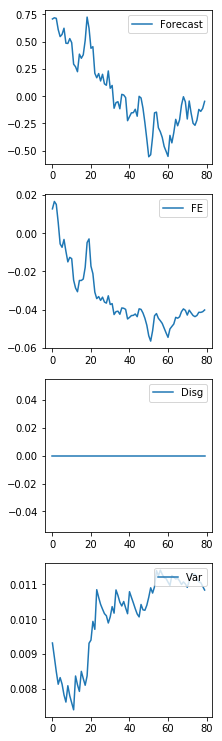

In [37]:
#pl_instance.ForecastPlot()

In [38]:
## compare the forecast from learning model with realized data
#plt.plot(pl_instance.realized)
#plt.plot(pl_moms_dct['Forecast'])